    Douglas Kosvoski
    1911100022

## Loading Libraries

In [1]:
!pip install tomotopy spacy > /dev/null

In [2]:
import sys
import spacy
import gensim

import pandas as pd
import tomotopy as tp
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from gensim.models.phrases import Phrases, Phraser
from bs4 import BeautifulSoup

spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [4]:
import warnings
warnings.filterwarnings('ignore')

## Loading dataset

In [5]:
""" The dataset is avaiable through google sheets api """
# https://docs.google.com/spreadsheets/d/1xdU55aEjDM-gdVWOm1UcSPmE0KcMFG5XHzs-9nyBTEA

sheet_id = "1xdU55aEjDM-gdVWOm1UcSPmE0KcMFG5XHzs-9nyBTEA"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet="

df = pd.concat([
  pd.read_csv(url + 'train').drop(['Id', 'CreationDate', 'Y'], axis=1),
  pd.read_csv(url + 'valid').drop(['Id', 'CreationDate', 'Y'], axis=1)
])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   60000 non-null  object
 1   Body    60000 non-null  object
 2   Tags    60000 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [7]:
def get_average_feature_length(docs, feature):
  total_size = 0
  max_size = 0
  min_size = 999

  for i in docs:
    length = len(i)
    total_size += length
  
    if length > max_size:
      max_size = length

    if length < min_size:
      min_size = length
    
  print(f"\n{'-'*10} {feature} {'-'*10}")
  print(f"Average # of {feature}: {int(total_size / len(docs))}")
  print(f"Max # of {feature}: {max_size}")
  print(f"Min # of {feature}: {min_size}")
  return int(total_size / len(docs))

avg_title_size = get_average_feature_length(df['Title'], 'Title')
avg_body_size  = get_average_feature_length(df['Body'], 'Body')
avg_tag_size   = get_average_feature_length(df['Tags'], 'Tags')


---------- Title ----------
Average # of Title: 53
Max # of Title: 150
Min # of Title: 7

---------- Body ----------
Average # of Body: 980
Max # of Body: 35288
Min # of Body: 7

---------- Tags ----------
Average # of Tags: 25
Max # of Tags: 112
Min # of Tags: 3


In [8]:
number_of_docs = 100
feature = df.Body

docs = list(feature)[:number_of_docs]
print(len(docs))

100


## Remove HTML tags

In [9]:
def remove_special_characters(character):
  if character.isalnum() or character in [' ', '.', '\n']:
    return True
  return False

def remove_tags(docs):
  cleaned_docs = []
  tags = r"<pre>|</pre>|<a|</a>|<img>|</img>|href|http"

  count = 0
  for doc in docs:
    print(f"{count} out of {len(docs)}", end="\r")
    split_string = re.split(tags, doc.strip().replace('\n', ''))
    clean_doc = ''

    for i in split_string:
      i = i.strip()
      if not (i.startswith('<code>') or i.startswith('=')):
        text = BeautifulSoup(i.strip(), "lxml").text
        asd = "".join(filter(remove_special_characters, text))
        clean_doc += asd

    cleaned_docs.append(clean_doc.strip())
    count += 1
  return cleaned_docs

In [10]:
docs_without_tags = remove_tags(docs)

In [11]:
for i, t in enumerate(zip(docs_without_tags[:10])):
  print(i, t)

0 ('Im already familiar with repeating tasks every n seconds by using Java.util.Timer and Java.util.TimerTask. But lets say I want to print Hello World to the console every random seconds from 15. Unfortunately Im in a bit of a rush and dont have any code to show so far. Any help would be apriciated.',)
1 ('Id like to understand why Java 8 Optionals were designed to be immutable.  Is it just for threadsafety',)
2 ('I am attempting to overlay a title over an image  with the image darkened with a lower opacity. However the opacity effect is changing the overlaying text as well  making it dim. Any fix to this Here is what is looks likesi.stack.imgur.com1HzD7.png relnoreferrersi.stack.imgur.com1HzD7.png altenter image description here',)
3 ('The question is very simple but I just could not find the answerWhy doesntcompile butdoesThis is really weird because all the other operators dont need an extra white space. e.g.are the same.I think it has something to do with optionals. But when you u

## Lematization

In [12]:
def lematize(docs):
  dlemma, total_size = [], len(docs)

  for i, d in enumerate(docs):
    print(f"{i} out of {total_size}", end='')
    lm = " ".join([token.lemma_ for token in nlp(d) if not (token.is_stop == True or token.is_digit == True or token.is_punct == True)])
    dlemma.append(lm.lower())
    print('\r\r\r\r\r\r\r\r', end='')
  return dlemma

In [13]:
dlemma = lematize(docs_without_tags)

In [14]:
for i in dlemma[:10]:
  print(i)

m familiar repeat task n second java.util timer java.util timertask lets want print hello world console random second unfortunately m bit rush not code far help apriciate
d like understand java optional design immutable   threadsafety
attempt overlay title image   image darken low opacity opacity effect change overlay text   make dim fix look likesi.stack.imgur.com1hzd7.png relnoreferrersi.stack.imgur.com1hzd7.png altenter image description
question simple find answerwhy doesntcompile butdoesthis weird operator not need extra white space e.g.are think optional use   operator variable like thisi mean follow operator right
m custom floatingactionmenu need implement scale animation showhide menu button like heresmaterialdesign.storage.googleapis.compublishmaterialv4materialextpublish0b6okdz75tqqszu1kzwhrywzpudgcomponentsbuttonsfabbehavior01xhdpi012.mp4 relnoreferrerfloating action button behaviour
define integer pointer inside structure want use member pointer structure pointer code show 

## Tokenization

In [15]:
min_length = 4
dtoken = [gensim.utils.simple_preprocess(d, deacc=True, min_len=min_length) for d in dlemma]

In [16]:
for i in dtoken[:10]:
  print(i)

['familiar', 'repeat', 'task', 'second', 'java', 'util', 'timer', 'java', 'util', 'timertask', 'lets', 'want', 'print', 'hello', 'world', 'console', 'random', 'second', 'unfortunately', 'rush', 'code', 'help', 'apriciate']
['like', 'understand', 'java', 'optional', 'design', 'immutable', 'threadsafety']
['attempt', 'overlay', 'title', 'image', 'image', 'darken', 'opacity', 'opacity', 'effect', 'change', 'overlay', 'text', 'make', 'look', 'likesi', 'stack', 'imgur', 'relnoreferrersi', 'stack', 'imgur', 'altenter', 'image', 'description']
['question', 'simple', 'find', 'answerwhy', 'doesntcompile', 'butdoesthis', 'weird', 'operator', 'need', 'extra', 'white', 'space', 'think', 'optional', 'operator', 'variable', 'like', 'thisi', 'mean', 'follow', 'operator', 'right']
['custom', 'need', 'implement', 'scale', 'animation', 'showhide', 'menu', 'button', 'like', 'storage', 'googleapis', 'okdz', 'tqqszu', 'xhdpi', 'action', 'button', 'behaviour']
['define', 'integer', 'pointer', 'inside', 'str

## N-grams

In [17]:
bigram  = Phraser(Phrases(dtoken, min_count=2, threshold=10))
bdocs   = [bigram[d] for d in dtoken]

In [18]:
def get_bigrams(docs):
  bigrams = []
  for doc in bdocs:
    for j in doc:
      if '_' in j and j not in bigrams:
        bigrams.append(j)

  return bigrams

In [19]:
print(get_bigrams(bdocs)[:10])

['java_util', 'stack_imgur', 'relnoreferrersi_stack', 'altenter_image', 'need_implement', 'image_description', 'form_form', 'thank_advance', 'stdcout_tinput', 'stdcin_clear']


### Bag of words

In [ ]:
def bow():
  for k in K:
    for a in alpha:
      for b in eta:
        for p in passes:
          lda = LdaModel(
            corpus          = corpus_bof,
            num_topics      = k,
            random_state    = 777,
            id2word         = dictionary,
            alpha           = a,
            eta             = b,
            per_word_topics = True,
            passes          = p
          )

          lda_cv  = CoherenceModel(
            model      = lda,
            texts      = bdocs,
            dictionary = dictionary,
            coherence  = 'c_v'
          )

          cv_cohe = lda_cv.get_coherence()

          print('K: %2d alfa: %10s beta: %10s passes: %3d coherence: %.3f'%(k, a, b, p, cv_cohe))
          cv.append(cv_cohe)

bow()

### TF-IDF

In [ ]:
def tfidf():
  for k in K:
    for a in alpha:
      for b in eta:
        for p in passes:
          lda = LdaModel(
            corpus          = corpus_tfidf,
            num_topics      = k,
            random_state    = 777,
            id2word         = dictionary,
            alpha           = a,
            eta             = b,
            per_word_topics = True,
            passes          = p
          )

          lda_cv  = CoherenceModel(
            model      = lda,
            texts      = bdocs,
            dictionary = dictionary,
            coherence  = 'c_v'
          )

          cv_cohe = lda_cv.get_coherence()

          print('K: %2d alfa: %10s beta: %10s passes: %3d coherence: %.3f'%(k, a, b, p, cv_cohe))
          cv.append(cv_cohe)

tfidf()

In [ ]:
print('# of docs: %5d # of words: %6d'%(dictionary.num_docs, len(list(dictionary.values()))))
print(list(dictionary.values()))

# of docs:   100 # of words:   1000
['apriciate', 'code', 'console', 'familiar', 'hello', 'help', 'java_util', 'lets', 'print', 'random', 'repeat', 'rush', 'second', 'task', 'timer', 'timertask', 'unfortunately', 'want', 'world', 'design', 'immutable', 'java', 'like', 'optional', 'threadsafety', 'understand', 'altenter_image', 'attempt', 'change', 'darken', 'description', 'effect', 'image', 'imgur', 'likesi', 'look', 'make', 'opacity', 'overlay', 'relnoreferrersi_stack', 'stack_imgur', 'text', 'title', 'answerwhy', 'butdoesthis', 'doesntcompile', 'extra', 'find', 'follow', 'mean', 'need', 'operator', 'question', 'right', 'simple', 'space', 'think', 'thisi', 'variable', 'weird', 'white', 'action', 'animation', 'behaviour', 'button', 'custom', 'googleapis', 'menu', 'need_implement', 'okdz', 'scale', 'showhide', 'storage', 'tqqszu', 'xhdpi', 'arei', 'belownow', 'compile', 'define', 'expectation', 'inside', 'integer', 'member', 'message', 'output', 'pointer', 'show', 'solve', 'structure', 

## Metrics

In [20]:
def stats_about_the_docs(docs, feature):
  total_size = 0
  max_size = 0
  min_size = 999

  for i in docs:
    length = len(i)
    total_size += length
  
    if length > max_size:
      max_size = length

    if length < min_size and length != 0:
      min_size = length
    
  print(f"{'-'*10} {feature} {'-'*10}")
  print(f"Average # of {feature}: {int(total_size / len(docs))}")
  print(f"Max # of {feature}: {max_size}")
  print(f"Min # of {feature}: {min_size}")

In [21]:
stats_about_the_docs(bdocs, 'Words')

---------- Words ----------
Average # of Words: 33
Max # of Words: 160
Min # of Words: 6


## Wordcloud

In [22]:
def create_single_string(tokens):
  output = ''
  for i in tokens:
    for j in i:
      output += j + " "

  return output

output = create_single_string(bdocs)
output

'familiar repeat task second java_util timer java_util timertask lets want print hello world console random second unfortunately rush code help apriciate like understand java optional design immutable threadsafety attempt overlay title image image darken opacity opacity effect change overlay text make look likesi stack_imgur relnoreferrersi_stack imgur altenter_image description question simple find answerwhy doesntcompile butdoesthis weird operator need extra white space think optional operator variable like thisi mean follow operator right custom need_implement scale animation showhide menu button like storage googleapis okdz tqqszu xhdpi action button behaviour define integer pointer inside structure want member pointer structure pointer code show belownow output expectation warning message compile warning message arei triedbut work solve warning want disable saturday saturday sunday public holiday date jquery calendar year saturday saturday sunday disable calendarplease help bootst

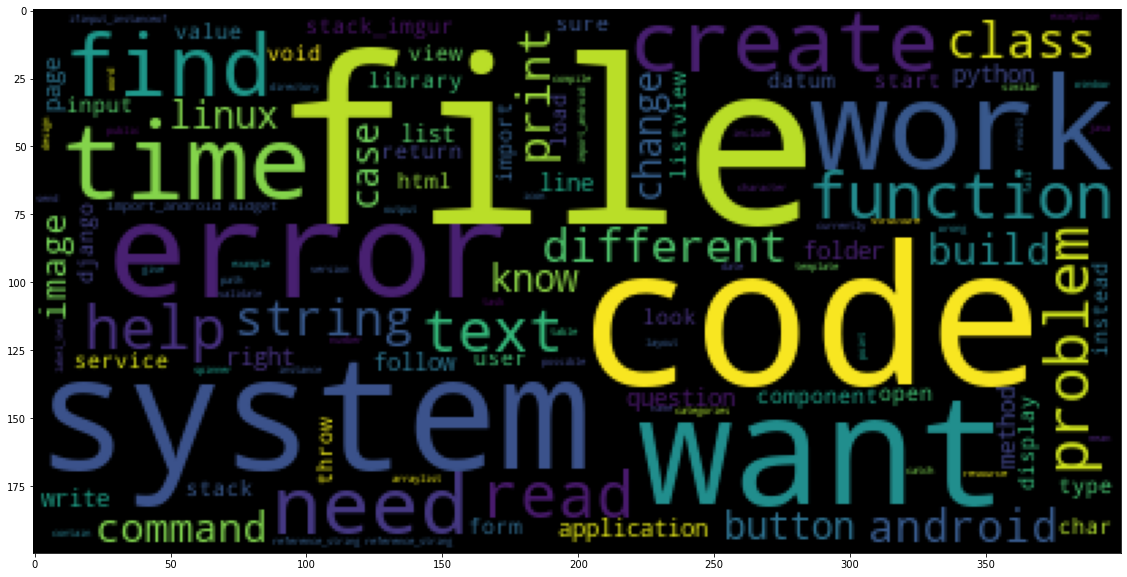

In [23]:
import wordcloud as wc
import matplotlib.pyplot as plt

mycloud = wc.WordCloud().generate(output)
plt.figure(figsize=(20,10))
plt.imshow(mycloud)

## Feature Extraction

In [35]:
def join_docs(docs):
  docs = []

  for i in bdocs:
    for j in i:
      docs.append(j)

  return docs

joined_docs = join_docs(bdocs)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(joined_docs)

features  = vectorizer.get_feature_names_out()
dense     = X.todense()
denseList = dense.tolist()

In [37]:
df = pd.DataFrame(denseList, columns=set(features))
for feature in df.columns:
  print(feature, df[feature].unique())

paste [0. 1.]
user [0. 1.]
datum [0. 1.]
equivalent [0. 1.]
lengthlong [0. 1.]
calculable [0. 1.]
namehere [0. 1.]
psql_command [0. 1.]
typescript [0. 1.]
boolean [0. 1.]
difficult [0. 1.]
ignore [0. 1.]
novice [0. 1.]
apriciate [0. 1.]
dependency [0. 1.]
produce [0. 1.]
console_readkey [0. 1.]
nooftourist [0. 1.]
thank [0. 1.]
overcome [0. 1.]
step [0. 1.]
uwsgi [0. 1.]
auto [0. 1.]
raise [0. 1.]
cluster [0. 1.]
getcontext [0. 1.]
argument [0. 1.]
online [0. 1.]
uitableview [0. 1.]
environment [0. 1.]
resourceaitem [0. 1.]
fsreqwrap [0. 1.]
googlesigninpod [0. 1.]
jabzd [0. 1.]
facebook [0. 1.]
kali [0. 1.]
appreciate [0. 1.]
poco [0. 1.]
initializer [0. 1.]
classwho [0. 1.]
animation [0. 1.]
generator [0. 1.]
action [0. 1.]
redundant [0. 1.]
bunch [0. 1.]
doest [0. 1.]
specifically [0. 1.]
link [0. 1.]
catch [0. 1.]
everytime [0. 1.]
spec [0. 1.]
directly [0. 1.]
child [0. 1.]
build [0. 1.]
naively [0. 1.]
componentsform [0. 1.]
plug [0. 1.]
near [0. 1.]
time_stop [0. 1.]
stdfclosest

## BoW & TF-idf

In [47]:
# from gensim.models.coherencemodel import CoherenceModel
# from gensim.corpora import Dictionary
# from gensim.models import TfidfModel
# from gensim.models import LdaModel

# dictionary = Dictionary(bdocs)
# print(dictionary)

# dictionary.filter_extremes(keep_n=1000, no_above=0.9, no_below=len(bdocs)*0.01) # no_below 1%
# print(dictionary)

Dictionary(1401 unique tokens: ['apriciate', 'code', 'console', 'familiar', 'hello']...)
Dictionary(16 unique tokens: ['code', 'help', 'want', 'like', 'text']...)


In [48]:
# corpus_bof   = [dictionary.doc2bow(d) for d in bdocs]
# tfidf        = TfidfModel(corpus_bof)
# corpus_tfidf = tfidf[corpus_bof]

# K = [10, 20, 30, 40]
# passes = [50, 100, 200]

# alpha, eta = ['symmetric', 'asymmetric', 'auto'], ['symmetric', 'auto']
# vocab = list(dictionary.values())

# print(f'# of docs: {dictionary.num_docs} \n# of words: {len(vocab)}')
# cv = []

# of docs: 100 
# of words: 16


In [ ]:
# for k in K:
#   for a in alpha:
#     for b in eta:
#       for p in passes:
#         lda = LdaModel(
#           corpus          = corpus_tfidf,
#           num_topics      = k,
#           random_state    = 777,
#           id2word         = dictionary,
#           alpha           = a,
#           eta             = b,
#           per_word_topics = True,
#           passes          = p
#         )

#         lda_cv = CoherenceModel(
#           model       =lda,
#           texts       = bdocs,
#           dictionary  = dictionary,
#           coherence   = 'c_v'
#         )
#         cv_cohe = lda_cv.get_coherence()

#         print('K: %2d | alfa: %10s | beta: %10s | passes: %3d coherence: %.3f' % (k, a, b, p, cv_cohe))
#         cv.append(cv_cohe)

## Model

In [27]:
def get_coherence(mdl):
	average_coherence = 0
	for preset in ['c_v']:
		coh = tp.coherence.Coherence(mdl, coherence=preset)
		average_coherence = coh.get_score()
	return average_coherence

def runModel(mdl, docs):
	for i, d in enumerate(docs):
		mdl.add_doc(d)
	
	mdl.burn_in = 100
	mdl.train(0)
 
	for i in range(0, 100, 2):
		mdl.train(10)
	# mdl.save('test.lda.bin', True)

def printTopics(mdl, p=False, top_n=10):
	for k in range(mdl.k):
		print(f" -> Topic #{k}")

		for word, prob in mdl.get_topic_words(topic_id=k, top_n=top_n):
			if p:
				print(f"{'%20s' % word} ({'%.2f' % prob})", end=" ")
			else:
	 			print(f"{word.strip()}", end=" ")
		print()

In [99]:
# tp.LDAModel docs
# bab2min.github.io/tomotopy/v0.4.1/en/#tomotopy.LDAModel

best_alpha, best_beta = None, None
alpha, beta = 2, 2

mdl, best_model = None, None
cv_scores = []
step = 1

for a in [alpha]:
  for b in [beta]:
    for i in range(1, len(bdocs)+1, step):
      print(f"{i} out of {len(bdocs)}")
      mdl = tp.LDAModel(
        tw      = tp.TermWeight.IDF,
        min_cf  = 3,
        rm_top  = 5,
        k       = i,
        seed    = 777,
        alpha   = a,
        eta     = b
      )

      runModel(mdl, bdocs)
      cv_scores.append(current_coherence)
      current_coherence = get_coherence(mdl)

      if current_coherence >= max(cv_scores):
        print(f"\n{'-'*10} Better params found!!! {'-'*10}")
        print(f"Alpha: {a} \t Beta: {b} \t Score: {'%.4f' % current_coherence}\n")
        best_model = mdl
        best_alpha = a
        best_beta  = b

1 out of 100
2 out of 100
3 out of 100
4 out of 100
5 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.8548

6 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.8664

7 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.8860

8 out of 100
9 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.8898

10 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.9006

11 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.9080

12 out of 100
13 out of 100
14 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.9112

15 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.9189

16 out of 100

---------- Better params found!!! ----------
Alpha: 2 	 Beta: 2 	 Score: 0.9253

17 out of 100
18 out of 100
19 out of 100
20 ou

In [100]:
print(cv_scores)

[0.8475024609252664, 0.37897870540618894, 0.7795406848192215, 0.7874488433202108, 0.8455031245946885, 0.8548327541351319, 0.8664336284001668, 0.8859878616673607, 0.8698980808258056, 0.889779767062929, 0.9006076347827913, 0.9080370279875669, 0.9021065359314281, 0.9004243814028227, 0.9112099064247949, 0.9189152073860167, 0.925315048545599, 0.9047403531916, 0.9111769765615464, 0.9083251193950049, 0.9172595435380932, 0.9042706878412338, 0.8945338476787914, 0.9015611301297727, 0.9016572937369348, 0.8921755166053774, 0.8968698526804263, 0.8960463607752764, 0.8924654492310115, 0.8923961107073161, 0.8959324477116267, 0.8895879164818793, 0.8844547040760516, 0.8844794549725272, 0.8870810011730471, 0.8846665600367956, 0.878065258761247, 0.8765319358658148, 0.8769977513112519, 0.8708743407176092, 0.8768421877920629, 0.8762011264882438, 0.8690884770382016, 0.8734243042247238, 0.8761585972525858, 0.8683976099226212, 0.8678353406812833, 0.864854391458187, 0.8639359174917143, 0.8660870898743065, 0.865

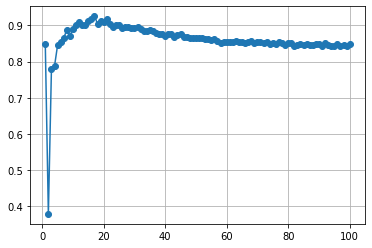

<Figure size 1080x720 with 0 Axes>


Highest coherence is doc #16 with 0.9253


In [104]:
plt.grid()
x = range(1, len(bdocs)+1, step)
plt.plot(x, cv_scores, marker='o')
plt.figure(figsize=(15, 10))
plt.show()

print(f"\nHighest coherence is doc #{max(zip(cv_scores, x))[1]-1} with {'%.4f' % max(zip(cv_scores, x))[0]}")

In [105]:
printTopics(best_model, p=True, top_n=10)

 -> Topic #0
           character (0.02)              instead (0.02)               offset (0.02)             suppress (0.02)                nodej (0.02)               implib (0.02)               action (0.01)                thing (0.01)             argument (0.01)                 have (0.01) 
 -> Topic #1
              folder (0.02)   services_runescape (0.02)                 word (0.01)                 task (0.01)                store (0.01)      javascript_file (0.01)                 boot (0.01)             operator (0.01)               answer (0.01)                imgur (0.01) 
 -> Topic #2
               linux (0.02)              service (0.02)              android (0.02)                 line (0.02)                mongo (0.02)            different (0.02)               server (0.01)              mongodb (0.01)              cordova (0.01)               driver (0.01) 
 -> Topic #3
      import_android (0.07)             listview (0.03)               widget (0.03)        import_google 